# Детектция границ листа бумаги

**Задача:**
Разработать скрипт, который будет с адекватным качеством находить границы листа бумаги на фотографии (лист бумаги лежит на столе, контрастность достаточная). 

Будем использовать открытый датасет ICDAR и алгоритм поиска границ Canny, который реализован в OpenCV.

### Подготовим датасет

In [ ]:
!unzip ./drive/MyDrive/1C_contest/ICDAR_dataset.zip

In [54]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from tqdm.notebook import tqdm

In [59]:
path = './ICDAR_dataset/'

Считаем все доступные имена файлов и целевые точки для предсказания

In [60]:
images_names = [x for x in os.listdir(path) if x[-4:] == '.jpg']

In [61]:
targets = []

for image_name in images_names:
    target = np.loadtxt(path + image_name + '.csv', delimiter=' ')
    targets.append(target)

### OpenCV

Откроем одно из изображений и посмотрим на него

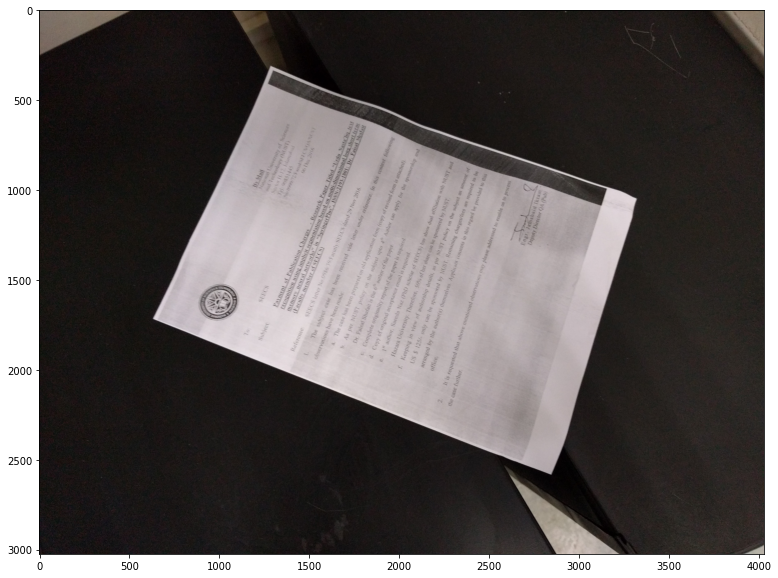

In [95]:
image = cv2.imread(path + images_names[0])
image = image[:,:,::-1]

plt.figure(figsize=(15, 10))
plt.imshow(image)
plt.show()

Теперь создадим его копию, а само изображение сожмем для усокрения работы с ним  и переведем в черно-белое

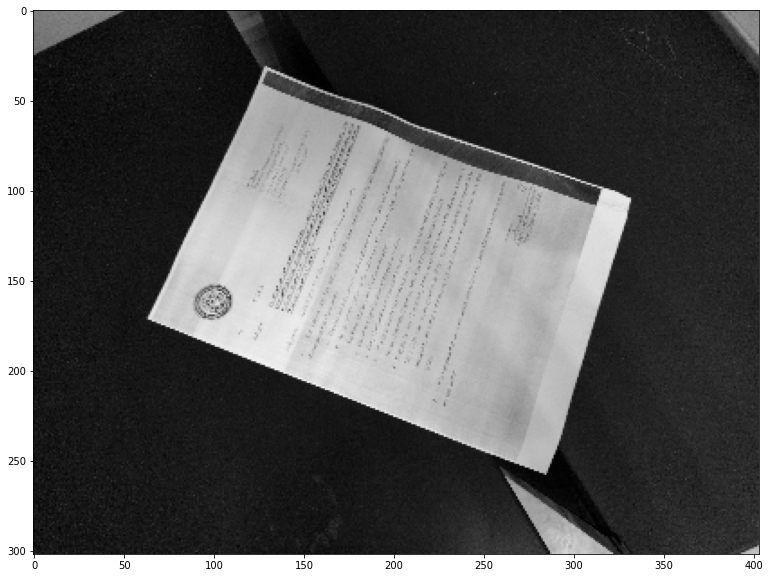

In [96]:
original = image.copy()
image = cv2.resize(image, (image.shape[1]//10, image.shape[0]//10))
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(15, 10))
plt.imshow(gray, cmap='gray')
plt.show()

Добавим на него Гауссовкий шум, чтобы избавиться от деталей, которые могут помешать поиску краем

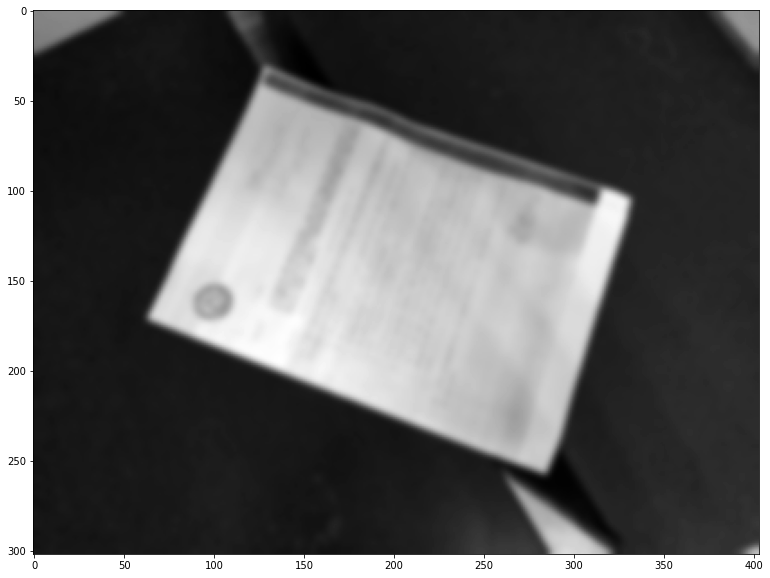

In [97]:
gray = cv2.GaussianBlur(gray, (11, 11), 0)

plt.figure(figsize=(15, 10))
plt.imshow(gray, cmap='gray')
plt.show()

С помощью алгоритма Кэнни, поставим трешхолды 40 и 100

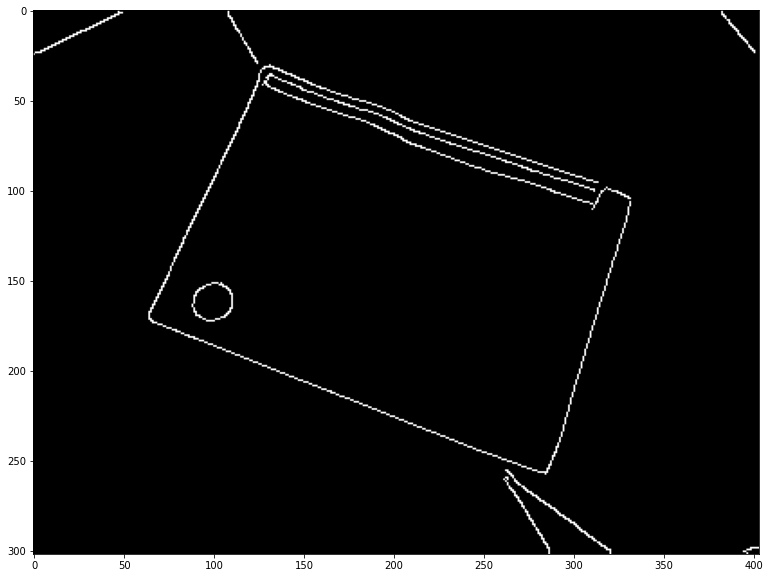

In [98]:
edged = cv2.Canny(gray, 40, 100)

plt.figure(figsize=(15, 10))
plt.imshow(edged, cmap='gray')
plt.show()

Применим простейшую эвристику поиска нужного контура -- у контура всего 4 угла, если такого нет, то берем с наибольшей площадью. Затем посмотрим на результат

In [85]:
def get_best(cnts, eps, best):
    for c in cnts:
        approx = cv2.approxPolyDP(c, eps * cv2.arcLength(c, True), True)
        if len(approx) == 4:
            return approx

    cnt = cnts[best]
    return cv2.approxPolyDP(cnt, eps * cv2.arcLength(cnt, True), True)

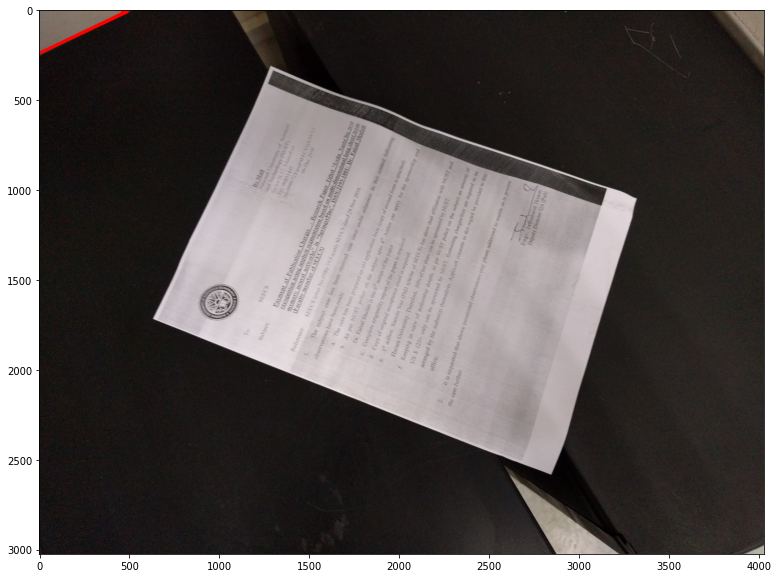

In [99]:
cnts = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts = sorted(cnts, key = cv2.contourArea, reverse=True)[:10]

paper_contour = get_best(cnts, 0.01, 0)
img = original.copy()
cv2.drawContours(img, [paper_contour * 10], -1, (255, 0, 0), 15)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Видно, что нашелся на лист бумаги. Попробуем применить другую эвристику: Не будем брать точки, если рядом с ними уже есть точки в этом контуре

In [94]:
def optimize_contours(cnts, delta):
    better_cnt = []
    for c in cnts:
        was = []
        for new_point in c:
            bad = False
            for prev_point in was:
                if ((new_point[0][0] - prev_point[0][0])**2 + (new_point[0][1] - prev_point[0][1])**2)**0.5 < delta:
                    bad = True
                    break
            if not bad:
                was.append(new_point)
        better_cnt.append(np.array(was))
    return better_cnt

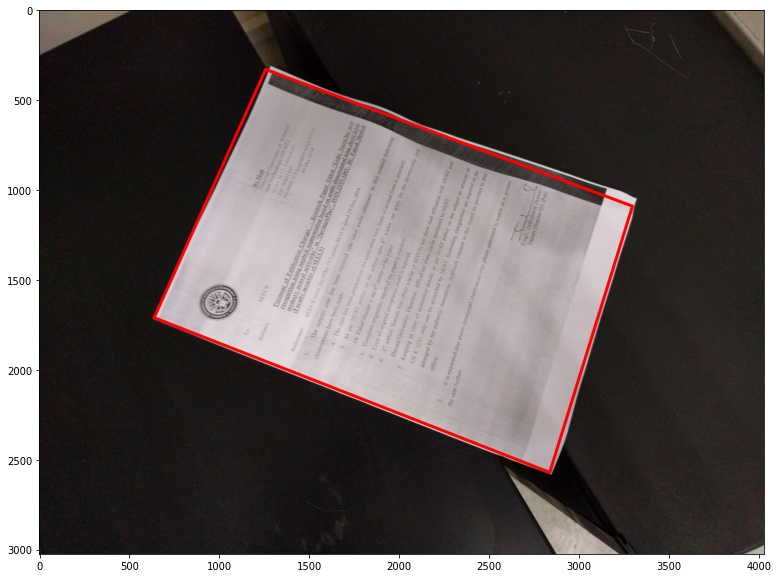

In [100]:
cnts = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts = optimize_contours(cnts, 5)
cnts = sorted(cnts, key = cv2.contourArea, reverse=True)[:10]

paper_contour = get_best(cnts, 0.01, 0)
cv2.drawContours(original, [paper_contour * 10], -1, (255, 0, 0), 15)

plt.figure(figsize=(15, 10))
plt.imshow(original)
plt.show()

Получили жедаемый результат. Проверим теперь его совпадение с ground truth. Определим функцию, котороя проверяет, что расстояние от наших угловых точек до требуемых не больше заданного числа

In [ ]:
def is_same(pred_contour, true_contours, eps=60):
    points = []
    for point in pred_contour:
        points.append((point[0][0], point[0][1]))
    
    for point in true_contours:
        contains = False
        for my_point in points:
            dist = ((my_point[0] - point[0])**2 + (my_point[1] - point[1])**2)**0.5
            if dist < eps:
                contains = True
                break
        if not contains:
            return False
    return True

In [106]:
same(paper_contour * 10, targets[0], eps=50)

True

Как можно видеть, мы правильно нашли листок бумаги и расстояние между найденными и требуемыми точками не более 50